# Implement of a Gaussian curvature, mean curvature

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim

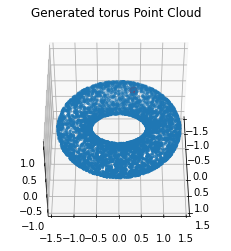

In [2]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a torus point cloud with 1000 points and radius 1
torus, torus_centers = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=5)
ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=50, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated torus Point Cloud")
ax.view_init(45, 0)
plt.show()

In [15]:
import sympy as sp
import scipy.optimize as opt

def max_value(expr, bounds):
    # Convert sympy expression to numpy function
    vars = list(expr.free_symbols)
    expr_neg = -1*expr
    neg_func = sp.lambdify([vars], expr_neg, 'numpy')

    # Minimize negative of function over range [-1, 1]
    bounds = [bounds for _ in vars]
    res = opt.minimize(neg_func, np.zeros(len(vars)), bounds=bounds)
    
    # Return maximum value
    return -res.fun

def manifold_density(f, variables):
    G = sp.Matrix.zeros(len(variables), len(variables))
    for i, x1 in enumerate(variables):
        for j, x2 in enumerate(variables):
            G[i,j] = (sp.diff(f, x1).T  * sp.diff(f, x2))[0]
    return sp.sqrt(G.det(method="lu"))

def rejection_sample_from_surface(
        F, # a sympy matrix of size $N \times 1$ representing a surface
        n_points, # number of points to sample
        bounds=[-1,1], # bounds for each variable
        batch_size=1024, # number of points to test sampling at a time
        verbose=False,
):
    if verbose: print("Hey, just woke up")
    vars = list(F.free_symbols)
    f = manifold_density(F, vars)
    g = 1/((bounds[1]-bounds[0])**len(vars)) # uniform density on [-1, 1] for each variable
    M = max_value(f/g, bounds=bounds) # M >= f/g for all x
    if verbose: print("Computed f, M, g")
    bouncer = (f / (M * g)) #.simplify()
    # print(bouncer)
    points = []
    # convert f to numpy
    F_np = sp.lambdify([vars], F, 'numpy')
    bouncer_np = sp.lambdify([vars], bouncer, 'numpy')
    # add the origin as first point
    points.append(F_np(np.zeros(len(vars))))
    if verbose: print("Computed bouncer np")
    while len(points) < n_points:

        euc_coords = np.random.uniform(bounds[0], bounds[1], (batch_size,len(vars)))
        x = np.array(list(map(F_np,euc_coords)))
        if verbose: print("computed sample candidates")
        u = np.random.uniform(0, 1, batch_size)
        # print(u)
        # compute mask of points that pass the bouncer
        bouncer_results = np.array(list(map(bouncer_np,euc_coords)))
        if verbose: print("computed bouncer results")
        mask = u < bouncer_results
        points.extend(x[mask])
        if verbose:
            print(f"Points added {np.sum(mask)} for a total of {len(points)}")
        # if u < bouncer_np(euc_coords):
        #     points.extend(x)
    if len(points) > n_points:
        points = points[:n_points]
    return np.squeeze(np.array(points))

def second_fundamental_form(F):
    vars = list(F.free_symbols)
    d = len(vars)
    N = len(F)
    H = np.zeros([d,d,N-d]) # d x d x (N-d); the last dimension holds the fk's
    for i, x1 in enumerate(vars):
        for j, x2 in enumerate(vars):
            H[j,i] = np.squeeze(sp.diff((sp.diff(F, x1)),x2).subs([(v,0) for v in vars]))[-(N-d):] # evaluate at the origin
    return H

def riemannian_curvature_tensor(F):
    H = second_fundamental_form(F)
    # print(H)
    N = H.shape[-1]
    d = H.shape[0]
    R = np.zeros((d,d,d,d))

    H2 = np.outer(H.flatten(), H.flatten()).reshape(H.shape + H.shape)
    HC = sum(H2[:,:,i,:,:,i] for i in range(H.shape[-1]))
    ida = [0,2,1,3]
    idb = [2,1,0,3]
    HC_a = np.transpose(HC, ida)
    HC_b = np.transpose(HC, idb)
    R = HC_a - HC_b # Gauss's formula for R_ijkl
    
    return R

def scalar_curvature_at_origin(F):
    R = riemannian_curvature_tensor(F)
    Ricc = sum([R[:,i,:,i] for i in range(R.shape[-1])])
    S = sum([Ricc[i,i] for i in range(Ricc.shape[-1])])
    # S = 0
    # for i in range(len(R)):
    #     for j in range(len(R)):
    #         S += R[i,j,i,j]
    return S

def rejection_sample_from_saddle(n_samples=1000, intrinsic_dim = 2, verbose=False, intensity=1):
    d = intrinsic_dim
    vars = sp.symbols('x0:%d' % d)
    saddle = sp.Matrix([*vars])
    for i in range(d,d+1):
        saddle = saddle.row_insert(i, sp.Matrix([intensity*sum([(-1)**j * vars[j]**2 for j in range(d)])]))
    if verbose: print(saddle)
    k = scalar_curvature_at_origin(saddle)
    return rejection_sample_from_surface(saddle, n_samples), k

In [29]:
X, k = rejection_sample_from_saddle(1000, 2, intensity=2)

In [33]:
k

-32.0

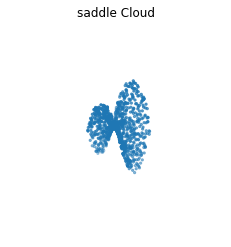

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=5)
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("saddle Cloud")
ax.view_init(40, 40)
plt.axis('off')
plt.show()

In [34]:
X, k = rejection_sample_from_saddle(1000, 3)
X

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.55168879,  0.48903977, -0.42942687,  0.24960806],
       [ 0.23227424,  0.02403968, -0.71854988,  0.56968735],
       ...,
       [ 0.24891695,  0.00395195, -0.45951226,  0.27309554],
       [-0.43590019,  0.2341465 , -0.02827481,  0.13598386],
       [-0.65128137,  0.21521954,  0.05620254,  0.3810067 ]])

In [4]:
def find_basis(point_cloud, x,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    return tau_nbrs, O
   
    
        
    

In [ ]:
def compute_curvatures(point_cloud, query_point, extrin_dim = 3, 
                       epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
    for i in range(extrin_dim - 1):
        for j in range(i+1, extrin_dim -1):
            
    else:
        O2 = O[2]

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return max_cur * min_cur, (max_cur + min_cur)/2
 

In [4]:
cloud = torus
idx = 1998
query = cloud[idx].reshape(1, -1)

In [5]:
tau_nbrs, O = find_basis(cloud, query,  epsilon_PCA = 0.2, tau_radius = 1)

In [38]:
for i in range(2):
    for j in range(i+1, 2):
        print((i, j))

(0, 1)


In [6]:
def compute_curvatures(point_cloud, query_point, extrin_dim = 3, 
                               epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
            
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return max_cur * min_cur, (max_cur + min_cur)/2
 

## Gaussian curvature 

In [6]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(torus, torus[i].reshape(1, -1), 
                                   epsilon_PCA =0.2, tau_radius = 1, max_min_num = 300)
    curvature.append(b)

100%|██████████| 5000/5000 [00:16<00:00, 298.84it/s]


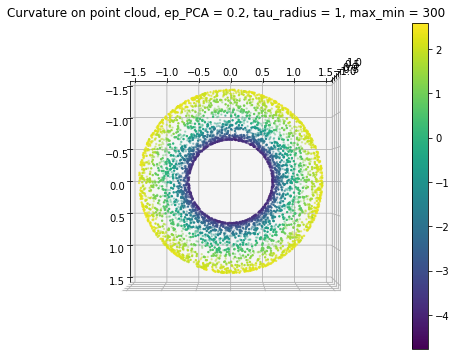

In [8]:
v = np.array(curvature).T
# Visualize the point cloud

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 300")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

## Mean curvature

In [65]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(torus, torus[i].reshape(1, -1), torus_centers[i], 
                               epsilon_PCA =0.2, tau_radius = 1, max_min_num = 300)
    curvature.append(b)

100%|██████████| 5000/5000 [00:13<00:00, 369.70it/s]


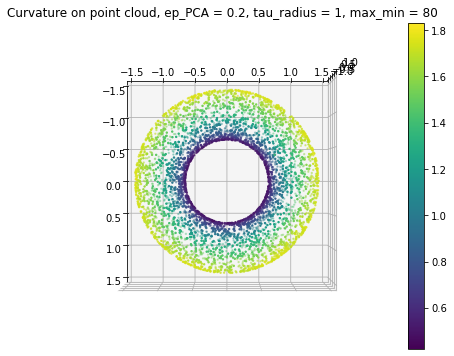

In [66]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = -v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 80")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

# On different dataset

In [25]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

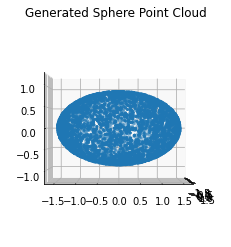

In [26]:
ellipsoid = generate_ellipsoid_cloud(0.9, 1.5, 0.9)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(0, 0)
plt.show()

## Gaussian curvature

In [57]:
num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), 
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 250)
    curvature.append(b)

100%|██████████| 5000/5000 [00:12<00:00, 414.18it/s]


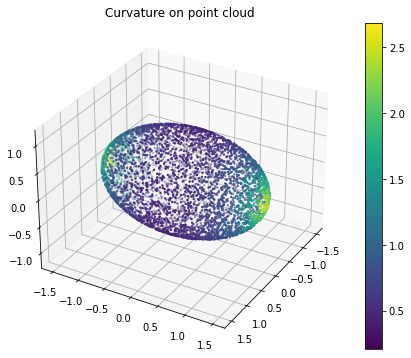

In [64]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(30, 30)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [59]:
def ellipsoid_ground_truth(point_cloud, a, b, c):
    #point_cloud: N by 3 array
    cur = []
    for p in point_cloud:
        k = 1 / (a **2 * b**2 * c**2 * (p[0]**2 / a**4 + p[1]**2 / b**4 + p[2]**2 / c**4) **2)
        cur.append(k)
    return cur

In [60]:
dd= np.array(ellipsoid_ground_truth(ellipsoid, 0.9, 1.5, 0.9))

In [62]:
from scipy.stats import pearsonr
corr, _ = pearsonr(dd, v)
corr

0.9922284424884587

## Mean curvature

In [41]:
ellipsoid_center = np.array([0, 0, 0])

num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), ellipsoid_center,
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 200)
    curvature.append(b)

100%|██████████| 5000/5000 [00:11<00:00, 417.47it/s]


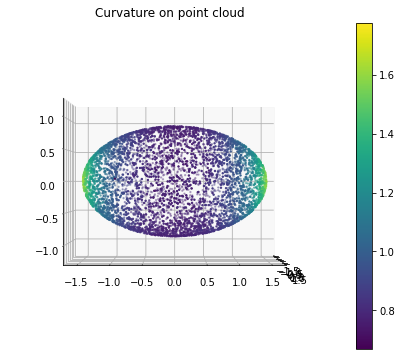

In [42]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()